In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [2]:
class SOBacktester(): 

    def __init__(self, symbol, periods, D_mw, start, end, tc):
        self.symbol = symbol
        self.periods = periods
        self.D_mw = D_mw
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "SOBacktester(symbol = {}, periods = {}, D_mw = {}, start = {}, end = {})".format(self.symbol, self.periods, self.D_mw, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("Nifty_ohlc.csv".format(self.symbol), parse_dates = [0], index_col = 0)
        raw = raw.dropna()
        raw = raw.loc[self.start:self.end]
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        raw["roll_low"] = raw.Low.rolling(self.periods).min()
        raw["roll_high"] = raw.High.rolling(self.periods).max()
        raw["K"] = (raw.Close - raw.roll_low) / (raw.roll_high - raw.roll_low) * 100
        raw["D"] = raw.K.rolling(self.D_mw).mean()
        self.data = raw
        
    def set_parameters(self, periods = None, D_mw = None):
        ''' Updates SO parameters and resp. time series.
        '''
        if periods is not None:
            self.periods = periods
            self.data["roll_low"] = self.data.Low.rolling(self.periods).min()
            self.data["roll_high"] = self.data.High.rolling(self.periods).max()
            self.data["K"] = (self.data.Close - self.data.roll_low) / (self.data.roll_high - self.data.roll_low) * 100
            self.data["D"] = self.data.K.rolling(self.D_mw).mean() 
        if D_mw is not None:
            self.D_mw = D_mw
            self.data["D"] = self.data.K.rolling(self.D_mw).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["K"] > data["D"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | periods = {}, D_mw = {} | TC = {}".format(self.symbol, self.periods, self.D_mw, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, SO):
        ''' Updates SO parameters and returns the negative absolute performance (for minimization algorithm).
        '''
        self.set_parameters(int(SO[0]), int(SO[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, periods_range, D_mw_range):
        ''' Finds global maximum given the SO parameter ranges.
        '''
        opt = brute(self.update_and_run, (periods_range, D_mw_range), finish=None)
        return opt, -self.update_and_run(opt)
    
    

In [3]:
tester = SOBacktester("Nifty50", 14, 3, "2008-01-01", "2022-07-01", 0.00004)

In [4]:
tester

SOBacktester(symbol = Nifty50, periods = 14, D_mw = 3, start = 2008-01-01, end = 2022-07-01)

In [5]:
tester.test_strategy()

(5.214983, 1.994063)

In [6]:
tester.results

,Open,High,Low,Close,returns,roll_low,roll_high,K,D,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,,,,,
2008-01-23,4903.049805,5328.049805,4891.600098,5203.399902,0.060220,4448.500000,6357.100098,39.552544,26.653925,1,0.060220,0.0,1.062070,1.062070
2008-01-24,5208.000000,5357.200195,4995.799805,5033.450195,-0.033207,4448.500000,6357.100098,30.648128,31.273356,-1,-0.033287,2.0,1.027382,1.027299
2008-01-25,5035.049805,5399.250000,5035.049805,5383.350098,0.067205,4448.500000,6357.100098,48.980931,39.727201,1,-0.067285,2.0,1.098800,0.960451
2008-01-28,5380.950195,5380.950195,5071.000000,5274.100098,-0.020503,4448.500000,6347.000000,43.486969,41.038676,1,-0.020503,0.0,1.076501,0.940960
2008-01-29,5279.549805,5391.600098,5225.250000,5280.799805,0.001269,4448.500000,6347.000000,43.839863,45.435921,-1,0.001189,2.0,1.077868,0.942080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24,15657.400391,15749.250000,15619.450195,15699.250000,0.009125,15183.400391,16514.300781,38.759445,26.393715,1,0.009125,0.0,3.204386,5.188214
2022-06-27,15926.200195,15927.450195,15815.500000,15832.049805,0.008423,15183.400391,16514.300781,48.737638,37.881100,1,0.008423,0.0,3.231492,5.232101
2022-06-28,15757.450195,15892.099609,15710.150391,15850.200195,0.001146,15183.400391,16492.800781,50.924057,46.140380,1,0.001146,0.0,3.235197,5.238100


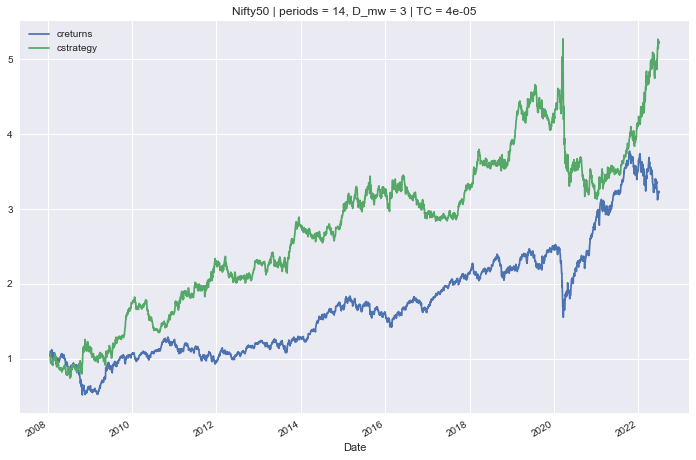

In [7]:
tester.plot_results()

In [8]:
tester.optimize_parameters((10, 100, 1), (3, 50, 1))

(array([36.,  3.]), 13.329288)

In [9]:
tester.test_strategy()

(13.329288, 10.289831)

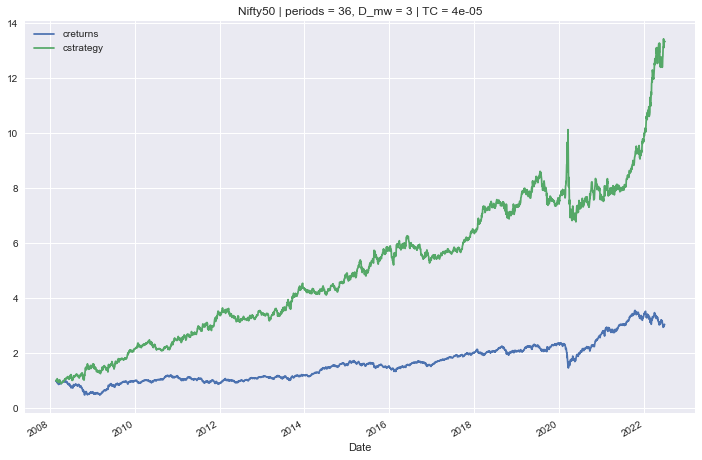

In [10]:
tester.plot_results()